In [ ]:
# Kirjastot

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# Datan lataaminen ja tarkastaminen
df = pd.read_csv('muokattu_twitter_dataset.csv')

df.head()

In [ ]:
# Valitaan tekstidata (Comments-sarake)
comments = df['Comment']

# Muunnetaan tekstidata numeeriseksi TF-IDF-vektorisoinnilla
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(comments)

In [ ]:
# Määritetään klusterien määrä (esimerkiksi 3: positiivinen, neutraali, negatiivinen)
k = 3

# K-means-algoritmin soveltaminen
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Lisätään klusteritieto dataan
df['Cluster'] = kmeans.labels_

# Näytetään muutamia rivejä klusteritiedolla
df[['Comment', 'Cluster']].head()



In [ ]:
# Tarkastellaan, kuinka monta viestiä kuuluu kuhunkin klusteriin
print(df.groupby('Cluster').size())

# Katsotaan esimerkkiviestejä jokaisesta klusterista
for cluster in range(k):
    print(f"\nCluster {cluster}:")
    print(df[df['Cluster'] == cluster]['Comment'].head(5).tolist())


In [ ]:
# Klustereiden tulkinta esimerkkiviestien perusteella
cluster_names = {
    0: "Negatiivinen",
    1: "Neutraali",
    2: "Positiivinen"
}

# Lisätään klusterin nimi dataan
df['Cluster_Label'] = df['Cluster'].map(cluster_names)

# Näytetään data klusterinimen kanssa
df[['Comment', 'Cluster', 'Cluster_Label']].head()


In [ ]:
# Visualisoidaan klusterien jakauma
cluster_counts = df['Cluster_Label'].value_counts()

plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Viestejä klustereittain")
plt.xlabel("Klusteri")
plt.ylabel("Viestimäärä")
plt.xticks(rotation=0)
plt.show()


2 käyttötapaus Viestien tulkinta

In [40]:
# Lasketaan tekstin ominaisuuksia jokaiselle viestille
df['Length'] = df['Comment'].apply(len)  # Merkkien määrä
df['Word_Count'] = df['Comment'].apply(lambda x: len(x.split()))  # Sanojen määrä
df['Avg_Word_Length'] = df['Length'] / df['Word_Count']  # Keskimääräinen sanan pituus
df['Exclamation_Count'] = df['Comment'].str.count(r'!')  # Huutomerkkejä
df['Dot_Count'] = df['Comment'].str.count(r'\.')  # Pisteitä

# Näytetään muutama rivi datasta uusilla ominaisuuksilla
df[['Comment', 'Length', 'Word_Count', 'Avg_Word_Length', 'Exclamation_Count', 'Dot_Count']].head()


,Comment,Length,Word_Count,Avg_Word_Length,Exclamation_Count,Dot_Count
0,is upset that he can't update his Facebook by ...,111,21,5.285714,1,4
1,@Kenichan I dived many times for the ball. Man...,89,18,4.944444,0,1
2,my whole body feels itchy and like its on fire,47,10,4.700000,0,0
3,"@nationwideclass no, it's not behaving at all....",111,21,5.285714,0,3
4,@Kwesidei not the whole crew,29,5,5.800000,0,0


In [41]:
# Ominaisuudet k-means-klusterointiin
features = ['Length', 'Word_Count', 'Avg_Word_Length', 'Exclamation_Count', 'Dot_Count']

# Normaaliarvoistus (tärkeää k-meansille)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# K-means-algoritmi
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster_Bot'] = kmeans.fit_predict(X_scaled)

# Klusterien jakauma
print(df['Cluster_Bot'].value_counts())


Cluster_Bot
0    248
1    166
2     85
Name: count, dtype: int64


In [42]:
# Esimerkkiviestit klustereista
for cluster in range(3):  # Kolme klusteria
    print(f"\nCluster {cluster} (Esimerkkiviestit):")
    print(df[df['Cluster_Bot'] == cluster]['Comment'].head(5).tolist())



Cluster 0 (Esimerkkiviestit):
['my whole body feels itchy and like its on fire ', '@Kwesidei not the whole crew ', 'Need a hug ', "@Tatiana_K nope they didn't have it ", '@twittera que me muera ? ']

Cluster 1 (Esimerkkiviestit):
['@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?", '@octolinz16 It it counts, idk why I did either. you never talk to me anymore ', "@smarrison i would've been the first, but i didn't have a gun.    not really though, zac snyder's just a doucheclown.", '@iamjazzyfizzle I wish I got to watch it with you!! I miss you and @iamlilnicki  how was the premiere?!']

Cluster 2 (Esimerkkiviestit):
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ", "

In [43]:
# Klusterien tulkinta
cluster_names_bot = {
    0: "Ihmisten viestit",
    1: "Bottiviestit",
    2: "Sekaryhmä"
}

# Lisätään klusterinimi dataan
df['Cluster_Bot_Label'] = df['Cluster_Bot'].map(cluster_names_bot)

# Näytetään data klusterinimen kanssa
df[['Comment', 'Cluster_Bot', 'Cluster_Bot_Label']].head()


,Comment,Cluster_Bot,Cluster_Bot_Label
0,is upset that he can't update his Facebook by ...,2,Sekaryhmä
1,@Kenichan I dived many times for the ball. Man...,1,Bottiviestit
2,my whole body feels itchy and like its on fire,0,Ihmisten viestit
3,"@nationwideclass no, it's not behaving at all....",2,Sekaryhmä
4,@Kwesidei not the whole crew,0,Ihmisten viestit


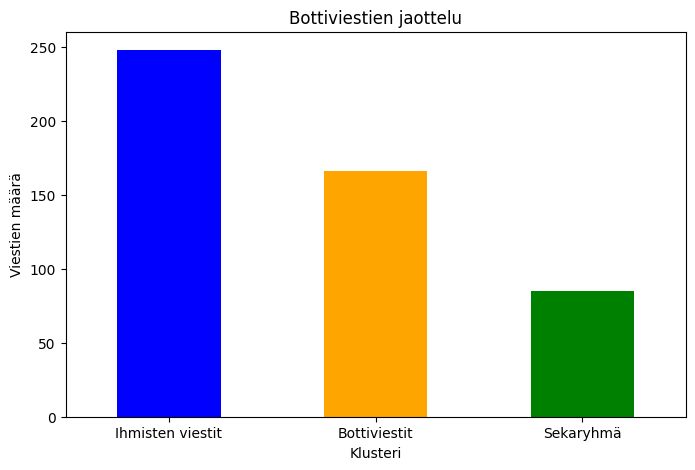

In [44]:
# Klusterien jakauman visualisointi
bot_counts = df['Cluster_Bot_Label'].value_counts()

plt.figure(figsize=(8, 5))
bot_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title("Bottiviestien jaottelu")
plt.xlabel("Klusteri")
plt.ylabel("Viestien määrä")
plt.xticks(rotation=0)
plt.show()
